## Worksheet 01
***

In [17]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
# Filter data 
X = np.array([data[i] for i in range(len(data)) if target[i] in [3, 8]])
X = np.c_[X, np.ones((X.shape[0], 1))]
y = np.array([target[i] for i in range(len(data)) if target[i] in [3, 8]])
# Relable
y = np.where(y==3, 1, y)
y = np.where(y==8, -1, y)
print("shape of X: ", X.shape)
print("shape of y: ", y.shape)

shape of X:  (357, 65)
shape of y:  (357,)


### 1.1. Classification with sklearn

In [4]:
# use cross validation to test the effect of eta
# and chose a proper eta value
Cs = [np.power(10.0, float(i)) for i in range(-10, 11, 2)]
means = []
stds = []
for c in Cs:
    log_reg = LogisticRegression(C=c, max_iter=1000)
    scores = model_selection.cross_val_score(log_reg, X, y, cv=20)
    means.append(scores.mean())
    stds.append(scores.std())

# show the data with pandas
pd_data = {
    "C": Cs,
    "mean": means,
    "std" : stds}
df = pd.DataFrame(pd_data)
display(df)

,C,mean,std
0,1.000000e-10,0.512745,0.020743
1,1.000000e-08,0.512745,0.020743
2,1.000000e-06,0.535458,0.057819
3,1.000000e-04,0.962582,0.066706
4,1.000000e-02,0.985948,0.038971
5,1.000000e+00,0.994281,0.017165
6,1.000000e+02,0.994281,0.017165
7,1.000000e+04,0.985621,0.031096
8,1.000000e+06,0.985621,0.040731
9,1.000000e+08,0.982680,0.052696


### 1.2. Optimization Methods

In [5]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def gradient(beta, X, y, C=1.0):  # C is the inverse of the regularization strength
    d_reg = beta * C  # derivative of the regularization part
    d_L = np.dot(X.T, sigmoid(-y * np.dot(X, beta)) * (-y)) / len(X)
    return d_L + d_reg

def predict(beta, X):
    y_pred = sigmoid(np.dot(X, beta))  # calculate the probability
    y_pred[y_pred>=0.5] = 1
    y_pred[y_pred<=0.5] = -1
    return y_pred

def zero_one_loss(y_prediction, y_truth):
    return np.sum(y_prediction!= y_truth)/len(y_truth)

def update_learning_rate(tau0, gamma, t):
    tau = tau0 / (1 + gamma * t)
    return tau

In [6]:
def gd(beta, X, y, tau0, m):
    for t in range(m):
        beta -= tau0 * gradient(beta, X, y)
    return beta


def sgd(beta, X, y, tau0, gamma, m):
    for t in range(m):
        index = np.random.choice(X.shape[0], size=1, replace=False)
        tau = update_learning_rate(tau0, gamma, t)
        beta -= tau * gradient(beta, X[index], y[index])
    return beta


def sg_minibatch(beta, X, y, tau0, gamma, m, batch_size):
    for t in range(m):
        B = np.random.choice(X.shape[0], size=batch_size, replace=False)
        tau = update_learning_rate(tau0, gamma, t)
        beta -= tau * gradient(beta, X[B], y[B])
    return beta


def sg_momentum(beta, X, y, tau0, mu, gamma, m):
    g = np.zeros(beta.shape)
    for t in range(m):
        index = np.random.choice(X.shape[0])
        tau = update_learning_rate(tau0, gamma, t)
        g = mu * g + (1 - mu) * gradient(beta, X[index], y[index])
        beta -= tau * g
    return beta


def ADAM(beta, X, y, tau0, m, mu1 = 0.9, mu2 = 0.999, eps = 1e-8):
    g = np.zeros(beta.shape)
    q = np.zeros(beta.shape)
    for t in range(m):
        index = np.random.choice(X.shape[0])
        l = gradient(beta, X[index], y[index])
        g = mu1 * g + (1 - mu1) * l
        q = mu2 * 1 + (1 - mu2) * l**2
        g_til = g / (1 - mu1 ** (t+1))
        q_til = q / (1 - mu2 ** (t+1))
        beta -= tau0 / (q_til**0.5 + eps ) * g_til
    return beta


def calculate_gi(yi, Xi, beta):
    return -yi * Xi * sigmoid(-yi * np.dot(Xi, beta))

def stochastic_average_gradient(beta, X, y, tau0, gamma, m):
    g_stored = np.zeros(X.shape)
    for i in range(X.shape[0]):
        g_stored[i] = calculate_gi(y[i], X[i], beta)
    g = np.mean(g_stored, axis=0)      
    for t in range(m):
        tau = update_learning_rate(tau0, gamma, t)
        i = np.random.choice(y.shape[0])
        gi = calculate_gi(y[i], X[i], beta)
        g += (gi - g_stored[i]) / y.shape[0]
        g_stored[i] = gi 
        beta = beta * (1 - tau / 1) - tau * g.T
    return beta
   

def dual_coordinate_ascent(beta, X, y, m, eps=1e-8):
    N = y.shape[0]
    alpha = np.random.uniform(0, 1, y.shape)
    beta = 1 / N * np.dot(X.T, y * alpha)
    for t in range(m):
        i = np.random.choice(X.shape[0])
        f1 = y[i] * np.dot(X[i], beta) + np.log(alpha[i] / (1 - alpha[i]))
        f2 = 1 / N * np.dot(X[i], X[i].T) + 1 / ((alpha[i])*(1 - alpha[i]))
        alpha_old = alpha[i]
        alpha[i] = np.clip(alpha[i] - f1 / f2, eps, 1 - eps)
        beta += (alpha[i] - alpha_old) * y[i] * X[i].T * 1 / N
    return beta


def newton_raphson(beta, X, y, m):
    for t in range(m):
        z = np.dot(X, beta)
        ytil = y / sigmoid(y * z) 
        W = np.diag(((sigmoid(z) * sigmoid(-z)) * 1 / X.shape[0]).reshape(-1,))
        beta = (np.linalg.inv(np.eye(X.shape[1]) + np.dot(X.T,W).dot(X))).dot(X.T).dot(W).dot(z + ytil)        
    return beta

### Learning Rate

In [7]:
tau_list = [0.001, 0.01, 0.1]
mu_list = [0.1, 0.2, 0.5]
gamma_list = [0.0001, 0.001, 0.01]

kf = model_selection.KFold(n_splits=10)

In [8]:
def test_gd(X, y):
    d = dict()  # d is to store the experiment data. Key: parameters (tau, mu, gamma) Value: error rate
    # split data into training and test set
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
    for tau in tau_list:
        for mu in mu_list:
            for gamma in gamma_list:
                err_sum = 0
                # use cross validation to calculate the error rate under a combination of parameter
                for train_index, val_index in kf.split(X_train):
                    Xk_train, X_validation = X_train[train_index], X_train[val_index]
                    yk_train, y_validation = y_train[train_index], y_train[val_index]
                    beta = np.random.rand(65)  # initialize beta
                    beta = gd(beta, Xk_train, yk_train, tau0=tau, m=10)
                    err_sum += zero_one_loss(predict(beta, X_validation), y_validation)
                err = err_sum / kf.get_n_splits()
                params = (tau, mu, gamma)
                d[params] = err
    min_err_param = sorted(d.items(), key=lambda x: x[1])[0]
    print(min_err_param)
    
test_gd(X, y)

((0.01, 0.1, 0.0001), 0.2733333333333334)


Gradient descent: $\tau = 0.01$

In [9]:
def test_sgd(X, y):
    d = dict()
    # split data into training and test set
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
    for tau in tau_list:
        for mu in mu_list:
            for gamma in gamma_list:
                err_sum = 0
                # use cross validation to calculate the error rate under a combination of parameter
                for train_index, val_index in kf.split(X_train):
                    Xk_train, X_validation = X_train[train_index], X_train[val_index]
                    yk_train, y_validation = y_train[train_index], y_train[val_index]
                    beta = np.random.rand(65)  # initialize beta
                    beta = sgd(beta, Xk_train, yk_train, tau0=tau, gamma=gamma, m=150)
                    err_sum += zero_one_loss(predict(beta, X_validation), y_validation)
                err = err_sum / kf.get_n_splits()
                params = (tau, mu, gamma)
                d[params] = err
    min_err_param = sorted(d.items(), key=lambda x: x[1])[0]
    print(min_err_param)
    
test_sgd(X, y)

((0.01, 0.2, 0.0001), 0.04016666666666667)


Stochastic gradient descent: $\tau_0 = 0.01$, $\gamma = 0.0001$

In [10]:
def test_sg_minibatch(X, y):
    d = dict()
    # split data into training and test set
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
    for tau in tau_list:
        for mu in mu_list:
            for gamma in gamma_list:
                err_sum = 0
                # use cross validation to calculate the error rate under a combination of parameter
                for train_index, val_index in kf.split(X_train):
                    Xk_train, X_validation = X_train[train_index], X_train[val_index]
                    yk_train, y_validation = y_train[train_index], y_train[val_index]
                    beta = np.random.rand(65)  # initialize beta
                    beta = sg_minibatch(beta, Xk_train, yk_train, tau0=tau, gamma=gamma, m=150, batch_size=16)
                    err_sum += zero_one_loss(predict(beta, X_validation), y_validation)
                err = err_sum / kf.get_n_splits()
                params = (tau, mu, gamma)
                d[params] = err
    min_err_param = sorted(d.items(), key=lambda x: x[1])[0]
    print(min_err_param)
    
test_sg_minibatch(X, y)

((0.01, 0.2, 0.0001), 0.016)


Minibatch gradient descent: $\tau_0 = 0.01$, $\gamma = 0.0001$

In [11]:
def test_sg_momentum(X, y):
    d = dict()
    # split data into training and test set
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
    for tau in tau_list:
        for mu in mu_list:
            for gamma in gamma_list:
                err_sum = 0
                # use cross validation to calculate the error rate under a combination of parameter
                for train_index, val_index in kf.split(X_train):
                    Xk_train, X_validation = X_train[train_index], X_train[val_index]
                    yk_train, y_validation = y_train[train_index], y_train[val_index]
                    beta = np.random.rand(65)  # initialize beta
                    beta = sg_momentum(beta, Xk_train, yk_train, tau0=tau, mu=mu, gamma=gamma, m=150)
                    err_sum += zero_one_loss(predict(beta, X_validation), y_validation)
                err = err_sum / kf.get_n_splits()
                params = (tau, mu, gamma)
                d[params] = err
    min_err_param = sorted(d.items(), key=lambda x: x[1])[0]
    print(min_err_param)
    
test_sg_momentum(X, y)

((0.1, 0.1, 0.01), 0.14)


Stochastic gradient momentum: $\tau_0 = 0.01$, $\mu = 0.5$, $\gamma = 0.01$

In [14]:
def test_sag(X, y):
    d = dict()
    # split data into training and test set
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
    for tau in tau_list:
        for mu in mu_list:
            for gamma in gamma_list:
                err_sum = 0
                # use cross validation to calculate the error rate under a combination of parameter
                for train_index, val_index in kf.split(X_train):
                    Xk_train, X_validation = X_train[train_index], X_train[val_index]
                    yk_train, y_validation = y_train[train_index], y_train[val_index]
                    beta = np.random.rand(65)  # initialize beta
                    beta = stochastic_average_gradient(beta, Xk_train, yk_train, tau0=tau, gamma=gamma, m=150)
                    err_sum += zero_one_loss(predict(beta, X_validation), y_validation)
                err = err_sum / kf.get_n_splits()
                params = (tau, mu, gamma)
                d[params] = err
    min_err_param = sorted(d.items(), key=lambda x: x[1])[0]
    print(min_err_param)
    
test_sag(X, y)

<ipython-input-5-fdb15c398ee3>:2: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1 + np.exp(-z))


((0.1, 0.5, 0.001), 0.26066666666666666)


Stochastic average gradient: $\tau_0 = 0.1$, $\gamma = 0.0001$

### Speed

In [15]:
def gd_speed(beta, X, y, X_test, y_test, tau0=0.01, m=100):
    err_rates = []
    for t in range(m):
        beta -= tau0 * gradient(beta, X, y)
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates


def sgd_speed(beta, X, y, X_test, y_test, tau0=0.01, gamma=0.0001, m=100):
    err_rates = []
    for t in range(m):
        index = np.random.choice(X.shape[0])
        tau = update_learning_rate(tau0, gamma, t)
        beta -= tau * gradient(beta, X[index], y[index])
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates


def sg_minibatch_speed(beta, X, y, X_test, y_test, tau0=0.01, gamma=0.0001, m=100, batch_size=16):
    err_rates = []
    for t in range(m):
        B = np.random.choice(X.shape[0], size=batch_size)
        tau = update_learning_rate(tau0, gamma, t)
        beta -= tau * gradient(beta, X[B], y[B])
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates


def sg_momentum_speed(beta, X, y, X_test, y_test, tau0=0.1, mu=0.5, gamma=0.01, m=100):
    err_rates = []
    g = np.zeros(beta.shape)
    for t in range(m):
        index = np.random.choice(X.shape[0])
        tau = update_learning_rate(tau0, gamma, t)
        g = mu * g + (1 - mu) * gradient(beta, X[index], y[index])
        beta -= tau * g
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates


def ADAM_speed(beta, X, y, X_test, y_test, tau0=0.0001, m=100, mu1 = 0.9, mu2 = 0.999, eps = 1e-8):
    err_rates = []
    g = np.zeros(beta.shape)
    q = np.zeros(beta.shape)
    for t in range(m):
        index = np.random.choice(X.shape[0])
        l = gradient(beta, X[index], y[index])
        g = mu1 * g + (1 - mu1) * l
        q = mu2 * 1 + (1 - mu2) * l**2
        g_til = g / (1 - mu1 ** (t+1))
        q_til = q / (1 - mu2 ** (t+1))
        beta -= tau0 / (q_til**0.5 + eps ) * g_til
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates


def calculate_gi(yi, Xi, beta):
    return -yi * Xi * sigmoid(-yi * np.dot(Xi, beta))

def sag_speed(beta, X, y, X_test, y_test, tau0=0.1, gamma=0.0001, m=100):
    err_rates = []
    g_stored = np.zeros(X.shape)
    for i in range(X.shape[0]):
        g_stored[i] = calculate_gi(y[i], X[i], beta)
    g = np.mean(g_stored, axis=0)      
    for t in range(m):
        tau = update_learning_rate(tau0, gamma, t)
        i = np.random.choice(X.shape[0])
        gi = calculate_gi(y[i], X[i], beta)
        g += (gi - g_stored[i]) / y.shape[0]
        g_stored[i] = gi 
        beta = beta * (1 - tau / 1) - tau * g.T
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates
   

def dual_coordinate_ascent_speed(beta, X, y, X_test, y_test, m, eps=1e-8):
    err_rates = []
    N = y.shape[0]
    alpha = np.random.uniform(0, 1, y.shape)
    beta = 1 / N * np.dot(X.T, y * alpha)
    for t in range(m):
        i = np.random.choice(X.shape[0])
        f1 = y[i] * np.dot(X[i], beta) + np.log(alpha[i] / (1 - alpha[i]))
        f2 = 1 / N * np.dot(X[i], X[i].T) + 1 / ((alpha[i])*(1 - alpha[i]))
        alpha_old = alpha[i]
        alpha[i] = np.clip(alpha[i] - f1 / f2, eps, 1 - eps)
        beta += (alpha[i] - alpha_old) * y[i] * X[i].T * 1 / N
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates


def newton_raphson_speed(beta, X, y, X_test, y_test, m):
    err_rates = []
    for t in range(m):
        z = np.dot(X, beta)
        weighted_labels = y / sigmoid(y * z) 
        W = np.diag(((sigmoid(z) * sigmoid(-z)) * 1 / X.shape[0]).reshape(-1,))
        beta = (np.linalg.inv(np.eye(X.shape[1]) + np.dot(X.T,W).dot(X))).dot(X.T).dot(W).dot(z + weighted_labels) 
#         err_rates.append(zero_one_loss(predict(beta, X), y))
        err_rates.append(zero_one_loss(predict(beta, X_test), y_test))
    return err_rates

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)


N = X_train.shape[0]
D = X_train.shape[1]
B = 16
sto_m = 5000

beta = np.zeros(65)
gd_err = gd_speed(beta, X_train, y_train, X_test, y_test, m=100)
gd_t = np.arange(100) * N * D

beta = np.zeros(65)
sgd_err = sgd_speed(beta, X_train, y_train, X_test, y_test, m=sto_m)
sgd_t = np.arange(sto_m) * D

beta = np.zeros(65)
sg_mini_err = sg_minibatch_speed(beta, X_train, y_train, X_test, y_test, m=500)
sg_mini_t = np.arange(500) * D * B

beta = np.zeros(65)
sg_momentum_err = sg_momentum_speed(beta, X_train, y_train, X_test, y_test, m=sto_m)
sg_momentum_t = np.arange(sto_m) * D

beta = np.zeros(65)
ADAM_err = ADAM_speed(beta, X_train, y_train, X_test, y_test, m=sto_m)
ADAM_t = np.arange(sto_m) * D

beta = np.zeros(65)
sag_err = sag_speed(beta, X_train, y_train, X_test, y_test, m=sto_m)
sag_t = np.arange(sto_m) * D

beta = np.random.uniform(65)
dcas_err = dual_coordinate_ascent_speed(beta, X_train, y_train, X_test, y_test, m=sto_m)
dcas_t = np.arange(sto_m) * D

beta = np.zeros(65)
nr_err = newton_raphson_speed(beta, X_train, y_train, X_test, y_test, m=500)
nr_t = np.arange(500) * N * D * D

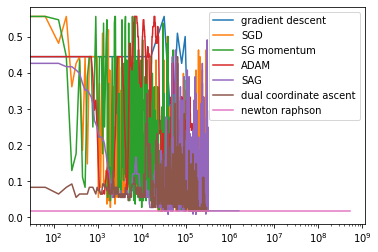

In [18]:
plt.plot(gd_t, gd_err, linestyle='-', label="gradient descent")
plt.plot(sgd_t, sgd_err, linestyle='-', label="SGD")
plt.plot(sg_momentum_t, sg_momentum_err, linestyle='-', label="SG momentum")
plt.plot(ADAM_t, ADAM_err, linestyle='-', label="ADAM")
plt.plot(sag_t, sag_err, linestyle='-', label="SAG")
plt.plot(dcas_t, dcas_err, linestyle='-', label="dual coordinate ascent")
plt.plot(nr_t, nr_err, linestyle='-', label="newton raphson")
plt.xscale("log")
plt.legend()

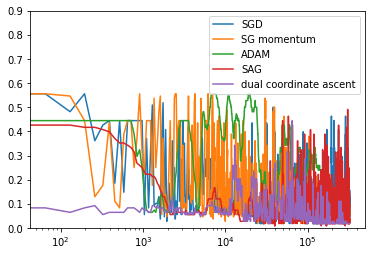

In [19]:
plt.plot(sgd_t, sgd_err, linestyle='-', label="SGD")
plt.plot(sg_momentum_t, sg_momentum_err, linestyle='-', label="SG momentum")
plt.plot(ADAM_t, ADAM_err, linestyle='-', label="ADAM")
plt.plot(sag_t, sag_err, linestyle='-', label="SAG")
plt.plot(dcas_t, dcas_err, linestyle='-', label="dual coordinate ascent")
plt.ylim([0, 0.9])
plt.xscale("log")
plt.legend()

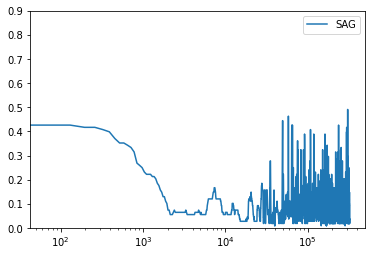

In [20]:
plt.plot(sag_t, sag_err, linestyle='-', label="SAG")
plt.ylim([0, 0.9])
plt.xscale("log")
plt.legend()

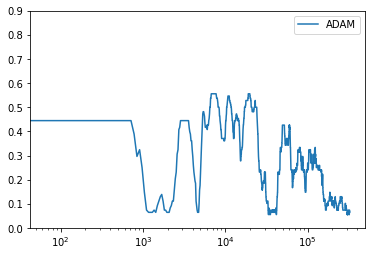

In [21]:
plt.plot(ADAM_t, ADAM_err, linestyle='-', label="ADAM")
plt.ylim([0, 0.9])
plt.xscale("log")
plt.legend()

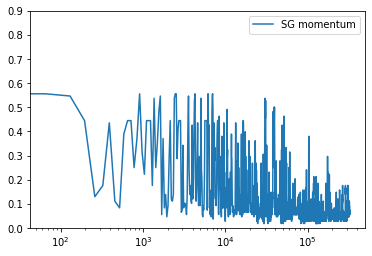

In [22]:
plt.plot(sg_momentum_t, sg_momentum_err, linestyle='-', label="SG momentum")
plt.ylim([0, 0.9])
plt.xscale("log")
plt.legend()

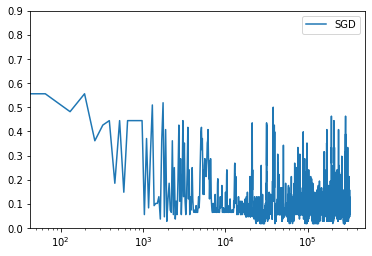

In [23]:
plt.plot(sgd_t, sgd_err, linestyle='-', label="SGD")
plt.ylim([0, 0.9])
plt.xscale("log")
plt.legend()

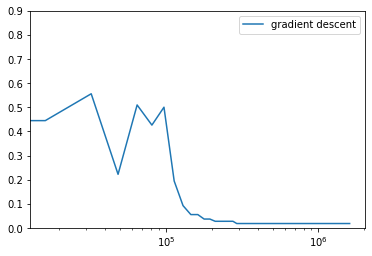

In [25]:
plt.plot(gd_t, gd_err, linestyle='-', label="gradient descent")
plt.ylim([0, 0.9])
plt.xscale("log")
plt.legend()


In [ ]:
We can conclude that stochastic gradie